Found 5 images.
Processing /content/drive/MyDrive/Image Dataset/00621.jpeg


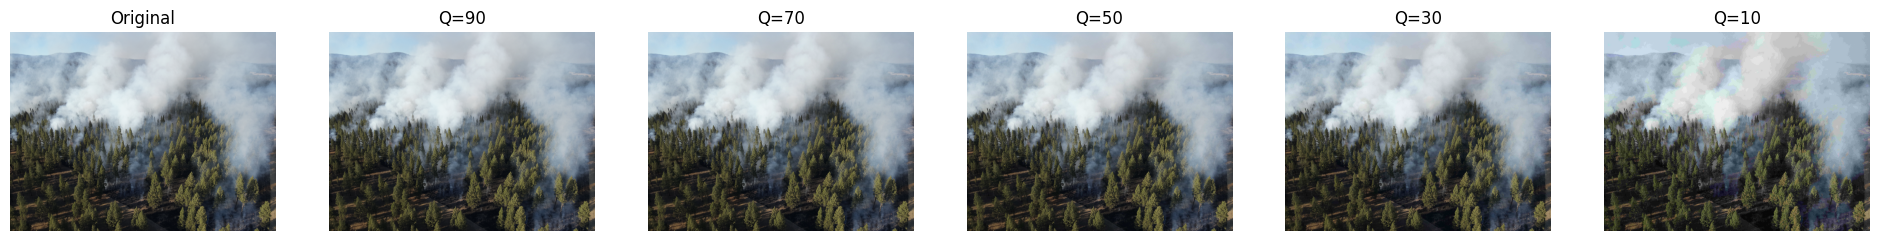

Processing /content/drive/MyDrive/Image Dataset/00619.jpeg


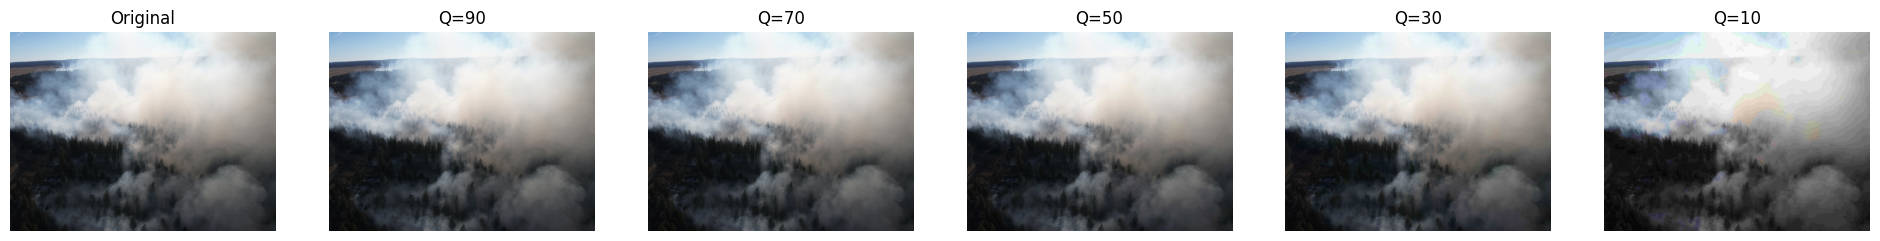

Processing /content/drive/MyDrive/Image Dataset/00618.jpeg


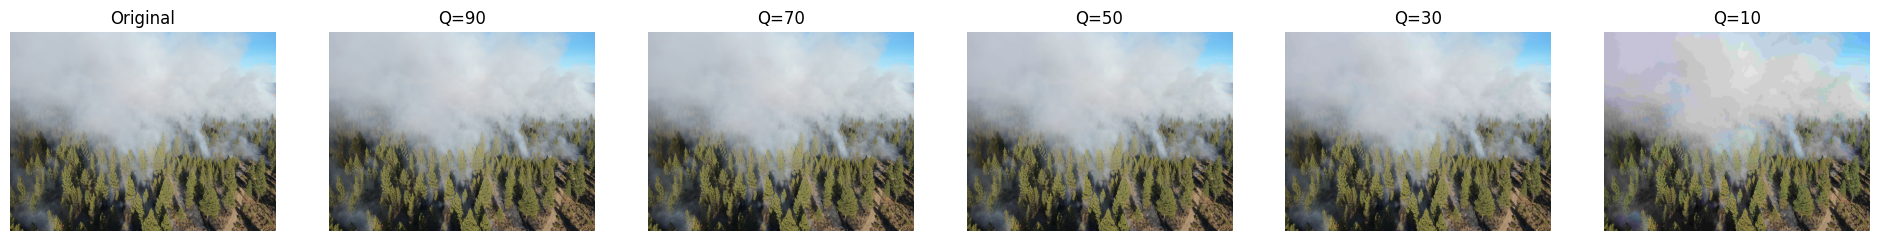

Processing /content/drive/MyDrive/Image Dataset/00617.jpeg


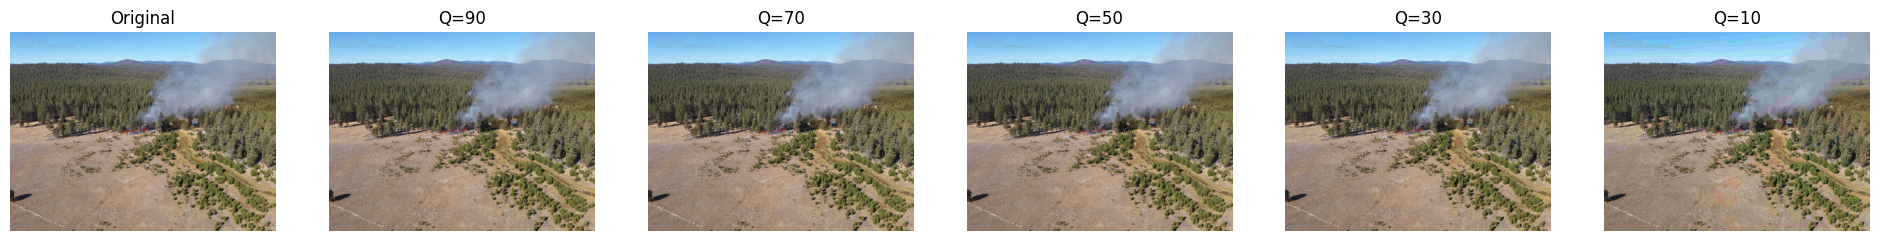

Processing /content/drive/MyDrive/Image Dataset/00620.jpeg


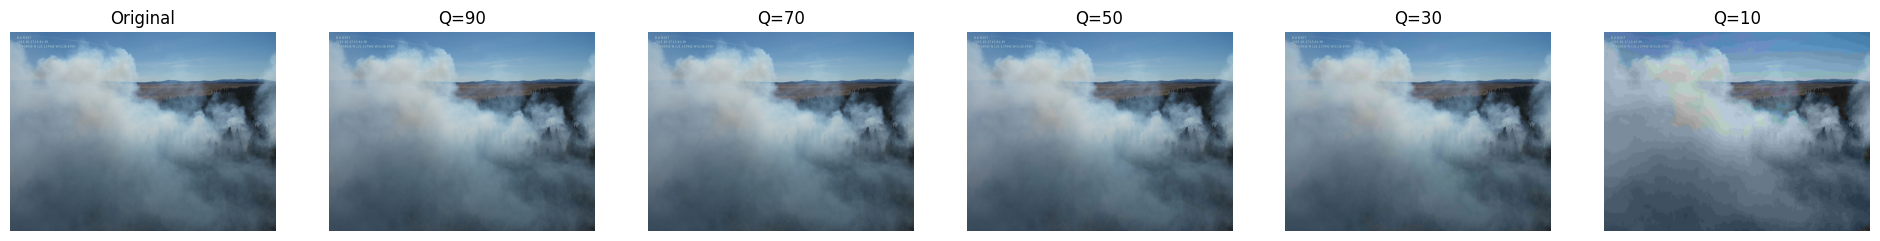

In [8]:
import os
import math
import pickle
import heapq
from collections import Counter, namedtuple
from itertools import count
from typing import List, Tuple

import numpy as np
from PIL import Image
from scipy.fftpack import dct, idct
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
import matplotlib.pyplot as plt

QY_BASE = np.array([
    [16,11,10,16,24,40,51,61],
    [12,12,14,19,26,58,60,55],
    [14,13,16,24,40,57,69,56],
    [14,17,22,29,51,87,80,62],
    [18,22,37,56,68,109,103,77],
    [24,35,55,64,81,104,113,92],
    [49,64,78,87,103,121,120,101],
    [72,92,95,98,112,100,103,99]
], dtype=np.float32)

QC_BASE = np.array([
    [17,18,24,47,99,99,99,99],
    [18,21,26,66,99,99,99,99],
    [24,26,56,99,99,99,99,99],
    [47,66,99,99,99,99,99,99],
    [99,99,99,99,99,99,99,99],
    [99,99,99,99,99,99,99,99],
    [99,99,99,99,99,99,99,99],
    [99,99,99,99,99,99,99,99]
], dtype=np.float32)

def rgb_to_ycbcr(img: np.ndarray) -> np.ndarray:
    img = img.astype(np.float32)
    R,G,B = img[...,0], img[...,1], img[...,2]
    Y  =  0.299*R + 0.587*G + 0.114*B
    Cb = -0.168736*R - 0.331264*G + 0.5*B + 128
    Cr = 0.5*R - 0.418688*G -0.081312*B +128
    return np.stack([Y,Cb,Cr], axis=-1)

def ycbcr_to_rgb(ycbcr: np.ndarray) -> np.ndarray:
    Y,Cb,Cr = ycbcr[...,0], ycbcr[...,1]-128, ycbcr[...,2]-128
    R = Y + 1.402*Cr
    G = Y -0.344136*Cb -0.714136*Cr
    B = Y + 1.772*Cb
    rgb = np.stack([R,G,B], axis=-1)
    return np.clip(rgb,0,255).astype(np.uint8)

def dct2(block): return dct(dct(block.T, norm='ortho').T, norm='ortho')
def idct2(block): return idct(idct(block.T, norm='ortho').T, norm='ortho')

def pad_to_block_size(channel, block_size=8):
    h,w = channel.shape
    pad_h = (block_size - h%block_size)%block_size
    pad_w = (block_size - w%block_size)%block_size
    padded = np.pad(channel, ((0,pad_h),(0,pad_w)), mode='constant')
    return padded, (pad_h,pad_w)

def blockify(channel, block_size=8):
    padded,_ = pad_to_block_size(channel, block_size)
    h,w = padded.shape
    blocks = padded.reshape(h//block_size, block_size, w//block_size, block_size)
    blocks = blocks.transpose(0,2,1,3).reshape(-1,block_size,block_size)
    return blocks

def unblockify(blocks, out_shape, block_size=8):
    H,W = out_shape
    Hpad = math.ceil(H/block_size)*block_size
    Wpad = math.ceil(W/block_size)*block_size
    blocks = blocks.reshape(Hpad//block_size, Wpad//block_size, block_size, block_size).transpose(0,2,1,3)
    arr = blocks.reshape(Hpad,Wpad)
    return arr[:H,:W]

def zigzag_scan(block):
    n = block.shape[0]
    result = []
    for s in range(2*n-1):
        if s%2==0:
            for i in range(s+1):
                j=s-i
                if i<n and j<n: result.append(int(block[i,j]))
        else:
            for j in range(s+1):
                i=s-j
                if i<n and j<n: result.append(int(block[i,j]))
    return result

def inverse_zigzag(arr,n=8):
    block = np.zeros((n,n), dtype=np.int32)
    idx=0
    for s in range(2*n-1):
        if s%2==0:
            for i in range(s+1):
                j=s-i
                if i<n and j<n: block[i,j]=arr[idx]; idx+=1
        else:
            for j in range(s+1):
                i=s-j
                if i<n and j<n: block[i,j]=arr[idx]; idx+=1
    return block

Node = namedtuple('Node', ['freq','symbol','left','right'])

class HuffmanCodec:
    def __init__(self):
        self.codes = {}
        self.decode_map = {}
    def build(self,data:List[int]):
        freq=Counter(data)
        heap=[]
        counter = count()
        for sym,f in freq.items():
            heapq.heappush(heap,(f,next(counter),Node(f,sym,None,None)))
        if len(heap)==0: return
        if len(heap)==1:
            f,_,node=heapq.heappop(heap)
            root=Node(f,None,node,None)
        else:
            while len(heap)>1:
                f1,_,n1=heapq.heappop(heap)
                f2,_,n2=heapq.heappop(heap)
                merged=Node(f1+f2,None,n1,n2)
                heapq.heappush(heap,(merged.freq,next(counter),merged))
            _,_,root=heapq.heappop(heap)

        self.codes={}
        def traverse(node,prefix):
            if node is None: return
            if node.symbol is not None:
                self.codes[node.symbol]=prefix or '0'
            else:
                traverse(node.left,prefix+'0')
                traverse(node.right,prefix+'1')
        traverse(root,'')
        self.decode_map={v:k for k,v in self.codes.items()}
    def encode(self,data:List[int]):
        if not self.codes: self.build(data)
        bitstr=''.join(self.codes[s] for s in data)
        pad_len=(8-(len(bitstr)%8))%8
        bitstr+='0'*pad_len
        b=int(bitstr,2).to_bytes(len(bitstr)//8,'big')
        return b, {'codebook':self.codes,'pad_len':pad_len}
    def decode(self,encoded_bytes,meta):
        codebook=meta['codebook']
        pad_len=meta.get('pad_len',0)
        rev={v:k for k,v in codebook.items()}
        bitstr=bin(int.from_bytes(encoded_bytes,'big'))[2:].zfill(len(encoded_bytes)*8)
        bitstr=bitstr[:len(encoded_bytes)*8-pad_len]
        out=[]
        cur=''
        for bit in bitstr:
            cur+=bit
            if cur in rev:
                out.append(rev[cur])
                cur=''
        return out

def scaled_quant_table(qtable_base, quality):
    if quality<50: scale=5000/quality
    else: scale=200-2*quality
    qt = np.floor((qtable_base*scale+50)/100)
    qt[qt==0]=1
    return qt

def quantize(block,qtable): return np.round(block/qtable)
def dequantize(block,qtable): return block*qtable

def compress_channel_lossy(channel,q_table_base,quality):
    qt = scaled_quant_table(q_table_base, quality)
    blocks = blockify(channel-128.0,8)
    all_symbols=[]
    for b in blocks:
        coeff=dct2(b)
        qblock=quantize(coeff, qt)
        zz=zigzag_scan(qblock)
        all_symbols.extend(zz)
        all_symbols.append(32767)
    codec=HuffmanCodec()
    codec.build(all_symbols)
    encoded_bytes, meta=codec.encode(all_symbols)
    meta_full={'codec_meta':meta,'q_table_base':q_table_base.tolist(),
               'quality':quality,'shape':channel.shape,'block_sep':32767}
    return encoded_bytes,meta_full

def decompress_channel_lossy(encoded_bytes,meta):
    codec=HuffmanCodec()
    codec.codes=meta['codec_meta']['codebook']
    codec.decode_map={v:k for k,v in codec.codes.items()}
    seq=codec.decode(encoded_bytes,meta['codec_meta'])
    qt = scaled_quant_table(np.array(meta['q_table_base']), meta['quality'])
    H,W = meta['shape']
    sep=meta['block_sep']
    blocks=[]
    cur=[]
    for s in seq:
        if s==sep:
            if cur: blocks.append(cur)
            cur=[]
        else: cur.append(s)
    block_mats=[]
    for arr in blocks:
        qblock=inverse_zigzag(arr,8)
        coeff=dequantize(qblock, qt)
        blk=idct2(coeff)
        block_mats.append(blk+128.0)
    return np.clip(unblockify(np.stack(block_mats), (H,W),8),0,255)

def main():
    dataset_dir='/content/drive/MyDrive/Image Dataset/'
    image_files=[os.path.join(dataset_dir,f) for f in os.listdir(dataset_dir)
                 if f.lower().endswith(('.jpg','.jpeg','.png'))]
    print(f"Found {len(image_files)} images.")
    Q_list=[90,70,50,30,10]

    for fpath in image_files:
        print("Processing",fpath)
        img = np.array(Image.open(fpath).convert('RGB'))
        ycbcr = rgb_to_ycbcr(img)
        rec_imgs=[]
        for Q in Q_list:
            rec_ch=[]
            for ch_idx in range(3):
                enc,meta=compress_channel_lossy(ycbcr[...,ch_idx], QY_BASE if ch_idx==0 else QC_BASE,Q)
                rec_ch.append(decompress_channel_lossy(enc,meta))
            rec = ycbcr_to_rgb(np.stack(rec_ch,axis=-1))
            rec_imgs.append((Q,rec))
        ncols=len(Q_list)+1
        plt.figure(figsize=(4*ncols,4))
        plt.subplot(1,ncols,1)
        plt.imshow(img); plt.title("Original"); plt.axis('off')
        for i,(Q,rec) in enumerate(rec_imgs):
            plt.subplot(1,ncols,i+2)
            plt.imshow(rec); plt.title(f"Q={Q}"); plt.axis('off')
        plt.show()

if __name__=="__main__":
    main()


In [15]:
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

def compute_metrics(original, reconstructed, compressed_bytes):
    orig_bytes = original.nbytes
    CR = orig_bytes / compressed_bytes
    bpp = (compressed_bytes * 8) / (original.shape[0] * original.shape[1])

    psnr_val = peak_signal_noise_ratio(original, reconstructed, data_range=255)

    min_dim = min(original.shape[0], original.shape[1])
    win_size = 7 if min_dim >= 7 else (min_dim if min_dim % 2 == 1 else min_dim-1)
    ssim_val = structural_similarity(original, reconstructed, data_range=255, multichannel=True, win_size=win_size, channel_axis=-1)

    return CR, bpp, psnr_val, ssim_val

dataset_dir='/content/drive/MyDrive/Image Dataset/'
image_files=[os.path.join(dataset_dir,f) for f in os.listdir(dataset_dir)
             if f.lower().endswith(('.jpg','.jpeg','.png'))]
Q_list=[90,70,50,30,10]

for fpath in image_files:
    print(f"\nFile: {os.path.basename(fpath)}")
    img = np.array(Image.open(fpath).convert('RGB'))
    ycbcr = rgb_to_ycbcr(img)

    for Q in Q_list:
        rec_ch=[]
        total_bytes = 0
        for ch_idx in range(3):
            enc,meta=compress_channel_lossy(ycbcr[...,ch_idx], QY_BASE if ch_idx==0 else QC_BASE,Q)
            rec_ch.append(decompress_channel_lossy(enc,meta))
            total_bytes += len(enc)

        rec = ycbcr_to_rgb(np.stack(rec_ch,axis=-1))
        CR, bpp, psnr_val, ssim_val = compute_metrics(img, rec, total_bytes)

        print(f" Q={Q:2d} | CR={CR:.2f} | bpp={bpp:.2f} | PSNR={psnr_val:.2f} dB | SSIM={ssim_val:.4f}")



File: 00621.jpeg
 Q=90 | CR=5.19 | bpp=4.63 | PSNR=41.94 dB | SSIM=0.9729
 Q=70 | CR=6.20 | bpp=3.87 | PSNR=38.31 dB | SSIM=0.9496
 Q=50 | CR=6.57 | bpp=3.66 | PSNR=36.64 dB | SSIM=0.9332
 Q=30 | CR=6.86 | bpp=3.50 | PSNR=34.82 dB | SSIM=0.9099
 Q=10 | CR=7.34 | bpp=3.27 | PSNR=29.88 dB | SSIM=0.8209

File: 00619.jpeg
 Q=90 | CR=6.08 | bpp=3.95 | PSNR=44.58 dB | SSIM=0.9713
 Q=70 | CR=6.88 | bpp=3.49 | PSNR=42.40 dB | SSIM=0.9543
 Q=50 | CR=7.10 | bpp=3.38 | PSNR=41.19 dB | SSIM=0.9447
 Q=30 | CR=7.26 | bpp=3.30 | PSNR=39.38 dB | SSIM=0.9320
 Q=10 | CR=7.51 | bpp=3.20 | PSNR=33.64 dB | SSIM=0.8941

File: 00618.jpeg
 Q=90 | CR=5.21 | bpp=4.61 | PSNR=41.96 dB | SSIM=0.9746
 Q=70 | CR=6.20 | bpp=3.87 | PSNR=38.20 dB | SSIM=0.9535
 Q=50 | CR=6.56 | bpp=3.66 | PSNR=36.48 dB | SSIM=0.9389
 Q=30 | CR=6.85 | bpp=3.50 | PSNR=34.63 dB | SSIM=0.9185
 Q=10 | CR=7.34 | bpp=3.27 | PSNR=29.39 dB | SSIM=0.8399

File: 00617.jpeg
 Q=90 | CR=4.28 | bpp=5.61 | PSNR=39.02 dB | SSIM=0.9769
 Q=70 | CR=5.44 